# **Question 26**

In [ ]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-o6xxya96
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-o6xxya96
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=2dd91470721f73a61d0c0a4db68f0f

In [ ]:
#Imports
from google.colab import drive
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import random
import plotly.express as px

In [ ]:
#mounting the drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='https://raw.githubusercontent.com/lgreski/pokemonData/master/Pokemon.csv', image_dir='gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    #print(pokedex)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)
    print(image_paths)
    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [ ]:
#load csv file and image paths to construct pokedex
pokedex = construct_pokedex(type_to_load=None)
pokedex.columns

['gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Bulbasaur/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Ivysaur/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Venusaur/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Charmander/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Charmeleon/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Charizard/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Squirtle/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Wartortle/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Blastoise/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mini

Index(['ID', 'Name', 'Form', 'Type1', 'Type2', 'Total', 'HP', 'Attack',
       'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'image_path'],
      dtype='object')

In [ ]:
#Checking the types of pokemons
unique_values = set(pokedex['Type1'].tolist())
print(unique_values)

{'Grass', 'Rock', 'Psychic', 'Water', 'Flying', 'Fire', 'Ground', 'Ghost', 'Ice', 'Normal', 'Dragon', 'Steel', 'Poison', 'Fairy', 'Fighting', 'Electric', 'Dark', 'Bug'}


In [ ]:
#Loading the clip model
clip_model,clip_preprocess,clip_device = load_clip_model()

100%|███████████████████████████████████████| 890M/890M [00:12<00:00, 72.4MiB/s]


In [ ]:
#Creating a new column for the image embeddings
image_paths = pokedex['image_path'].tolist()
print(image_paths)
inference_image = clip_inference_image(clip_model,clip_preprocess,image_paths,clip_device)
pokedex['image_embeddings'] = list(inference_image)

['gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Bulbasaur/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Ivysaur/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Charmander/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Charmeleon/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Squirtle/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Wartortle/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Caterpie/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Metapod/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Mining/Project 2/images//Butterfree/0.jpg', 'gdrive/My Drive//Winter Quarter 2024/219 - Large Scale Data Minin

100%|██████████| 754/754 [45:57<00:00,  3.66s/it]


In [ ]:
#Creating queries to experiment
queries = [
    "type: Bug",
    "type: Electric",
    "type: Fire",
]

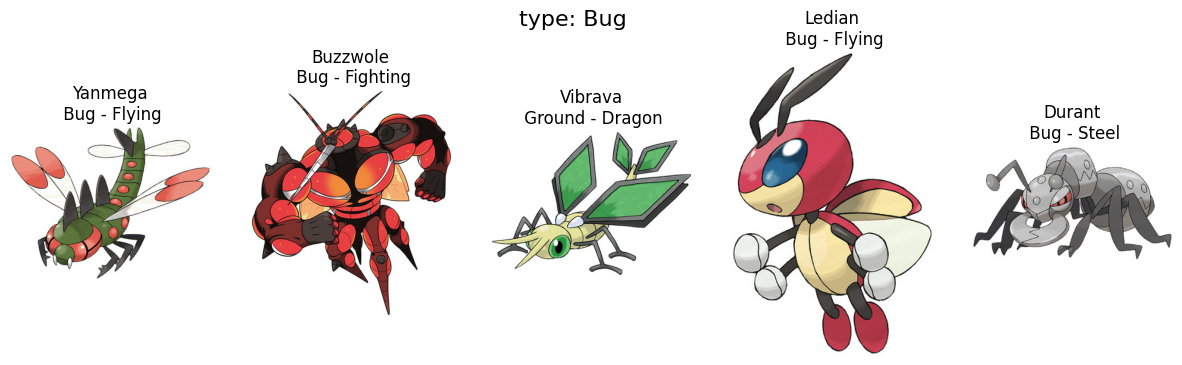

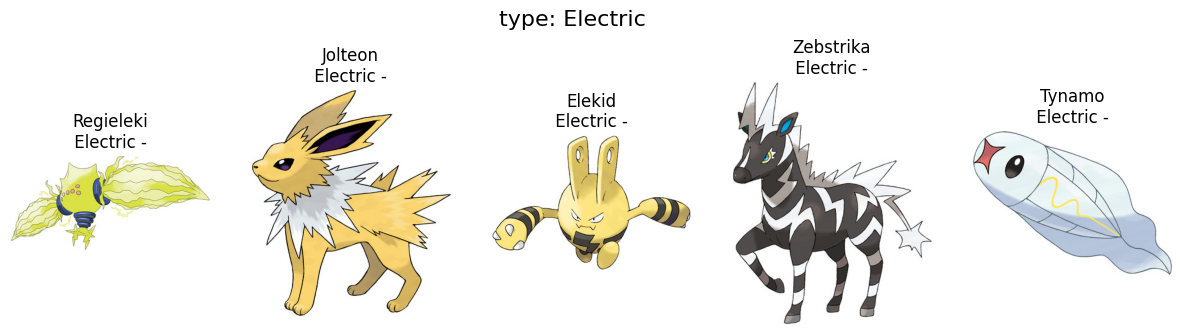

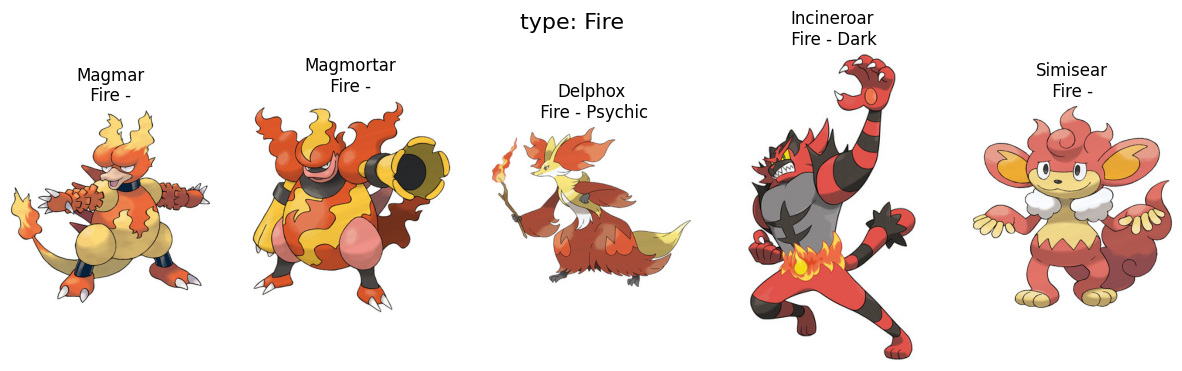

In [ ]:
# Plotting the top five most relevant Pokemon for each query
for query in queries:
    # Inference on text query
    text_embeddings = clip_inference_text(clip_model, clip_preprocess, [query], clip_device)

    # Flatten text embeddings to ensure compatibility with the shape of image embeddings
    text_embeddings = text_embeddings.flatten()

    # Compute similarity of text query to each image
    similarity = compute_similarity_text_to_image(np.array(pokedex['image_embeddings'].tolist()), text_embeddings)

    # Get top five indices
    top_five_indices = np.argsort(similarity)[::-1][:5]

    # Plotting
    plt.figure(figsize=(15, 4))
    plt.suptitle(query, fontsize=16)
    for i, index in enumerate(top_five_indices):
        plt.subplot(1, 5, i+1)
        img = Image.open(pokedex.loc[index, 'image_path'])
        plt.imshow(img)
        plt.title(f"{pokedex.loc[index, 'Name']}\n {pokedex.loc[index, 'Type1']} - {pokedex.loc[index, 'Type2']}")
        plt.axis('off')
    plt.show()

In [ ]:
#creating queries as asked in the question
queries = [
    "type: Bug",
    "type: Fire",
    "type: Grass"
]

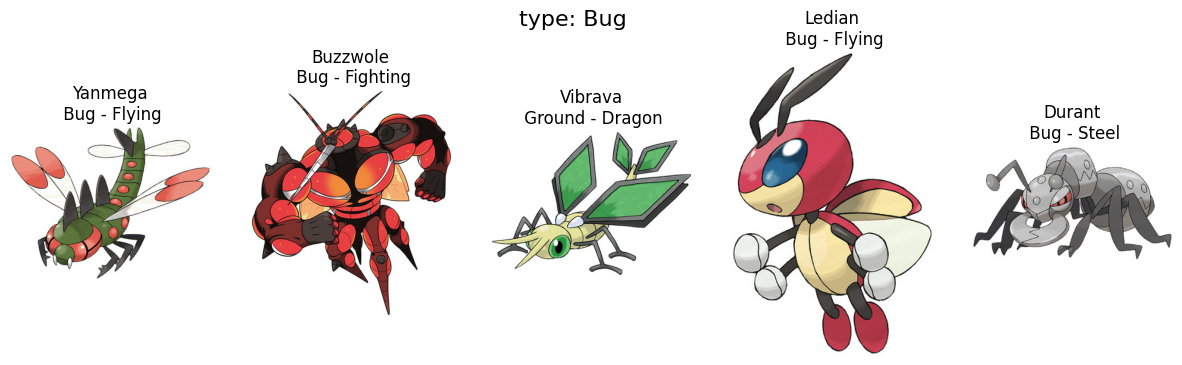

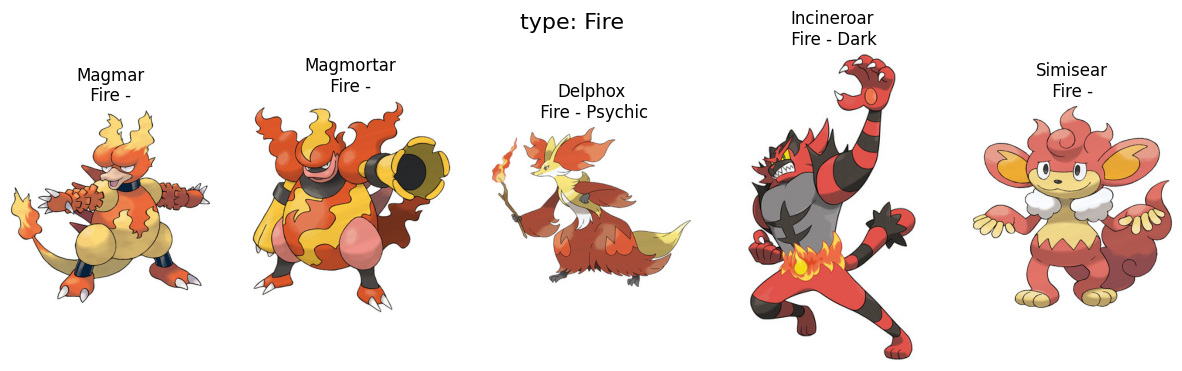

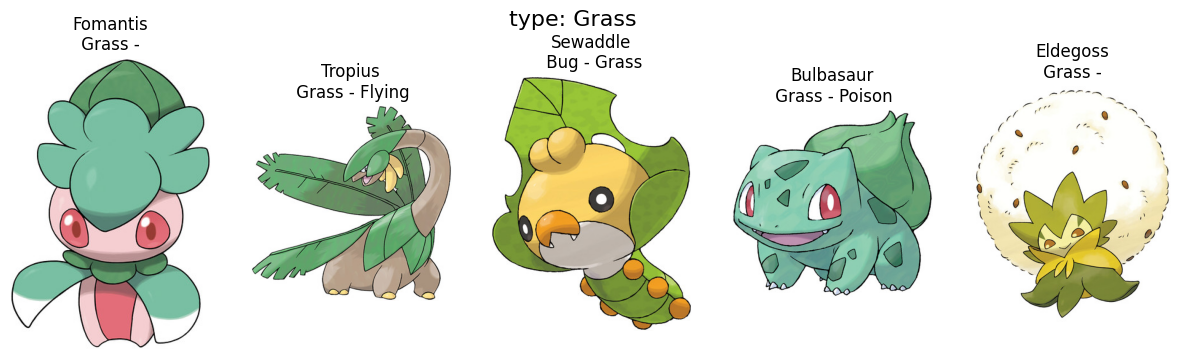

In [ ]:
# Plotting the top five most relevant Pokemon for each query
for query in queries:
    # Inference on text query
    text_embeddings = clip_inference_text(clip_model, clip_preprocess, [query], clip_device)

    # Flatten text embeddings to ensure compatibility with the shape of image embeddings
    text_embeddings = text_embeddings.flatten()

    # Compute similarity of text query to each image
    similarity = compute_similarity_text_to_image(np.array(pokedex['image_embeddings'].tolist()), text_embeddings)

    # Get top five indices
    top_five_indices = np.argsort(similarity)[::-1][:5]

    # Plotting
    plt.figure(figsize=(15, 4))
    plt.suptitle(query, fontsize=16)
    for i, index in enumerate(top_five_indices):
        plt.subplot(1, 5, i+1)
        img = Image.open(pokedex.loc[index, 'image_path'])
        plt.imshow(img)
        plt.title(f"{pokedex.loc[index, 'Name']}\n {pokedex.loc[index, 'Type1']} - {pokedex.loc[index, 'Type2']}")
        plt.axis('off')
    plt.show()

In [ ]:
queries = [
    "type: Dark",
    "type: Dragon"
]

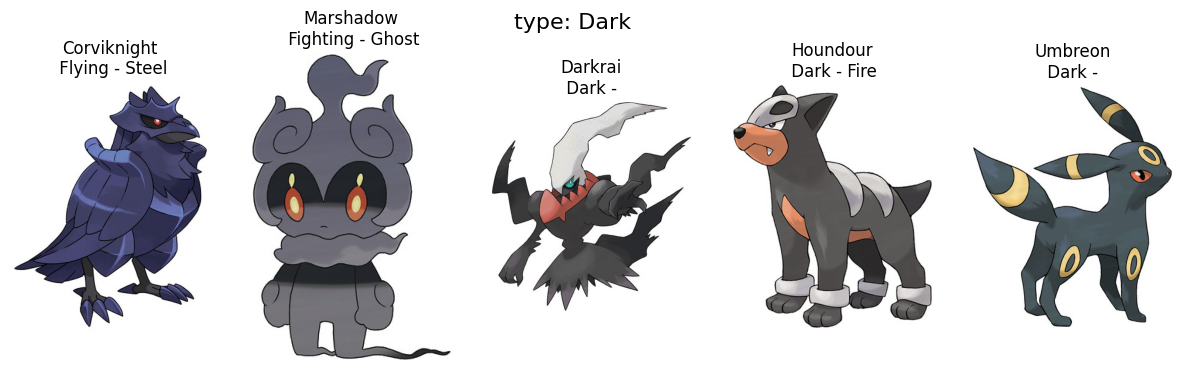

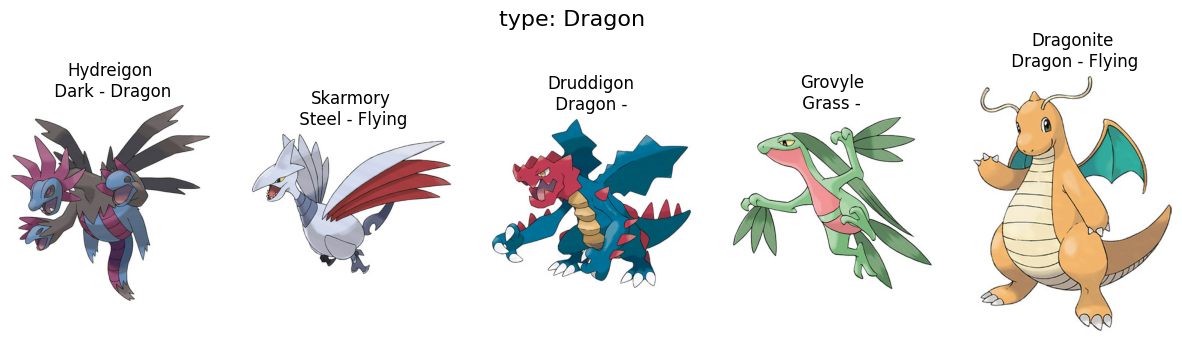

In [ ]:
# Plotting the top five most relevant Pokemon for each query
for query in queries:
    # Inference on text query
    text_embeddings = clip_inference_text(clip_model, clip_preprocess, [query], clip_device)

    # Flatten text embeddings to ensure compatibility with the shape of image embeddings
    text_embeddings = text_embeddings.flatten()

    # Compute similarity of text query to each image
    similarity = compute_similarity_text_to_image(np.array(pokedex['image_embeddings'].tolist()), text_embeddings)

    # Get top five indices
    top_five_indices = np.argsort(similarity)[::-1][:5]

    # Plotting
    plt.figure(figsize=(15, 4))
    plt.suptitle(query, fontsize=16)
    for i, index in enumerate(top_five_indices):
        plt.subplot(1, 5, i+1)
        img = Image.open(pokedex.loc[index, 'image_path'])
        plt.imshow(img)
        plt.title(f"{pokedex.loc[index, 'Name']}\n {pokedex.loc[index, 'Type1']} - {pokedex.loc[index, 'Type2']}")
        plt.axis('off')
    plt.show()

QUESTION 26: Try to construct various text queries regarding types of Pokemon (such as ”type: Bug”, ”electric type Pok ́emon” or ”Pok ́emon with fire abilities”) to find the relevant images from the dataset. Once you have found the most suitable template for queries, please find the top five most relevant Pokemon for type Bug, Fire and Grass. For each of the constructed query, please plot the five most relevant Pokemon horizontally in one figure with following specifications:
* the title of the figure should be the query you used;
* the title of each Pokemon should be the name of the Pokemon and its first and second type.
Repeat this process for Pokemon of Dark and Dragon types. Assess the effectiveness of your queries in these cases as well and try to explain any differences.

> We can see the relevant 5 pokemons above.

>We can see that the queries are running pretty accurately from the output pokemons that we have received. The differences are observed due to the model's understanding of textual descriptions and the complexity of the dataset.

# **Question 27**

In [ ]:
# Randomly select 10 Pokemon images
random.seed(0)  # Setting seed for reproducibility
# Randomly select 10 Pokémon images
selected_pokemon_indices = random.sample(range(len(pokedex)), 10)
selected_pokemon = pokedex.loc[selected_pokemon_indices]

------------------Pokemon No  395  -----------------------


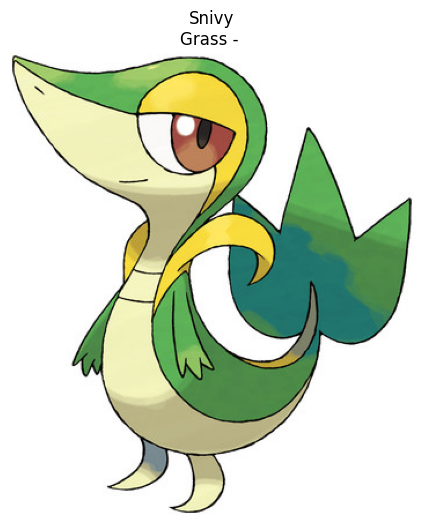

Top five types are:  ['Grass', 'Bug', 'Rock', 'Fighting', 'Ghost']
Top five probabilities are:  [0.044443645, 0.028661663, 0.01337572, 0.013232502, 0.013226294]


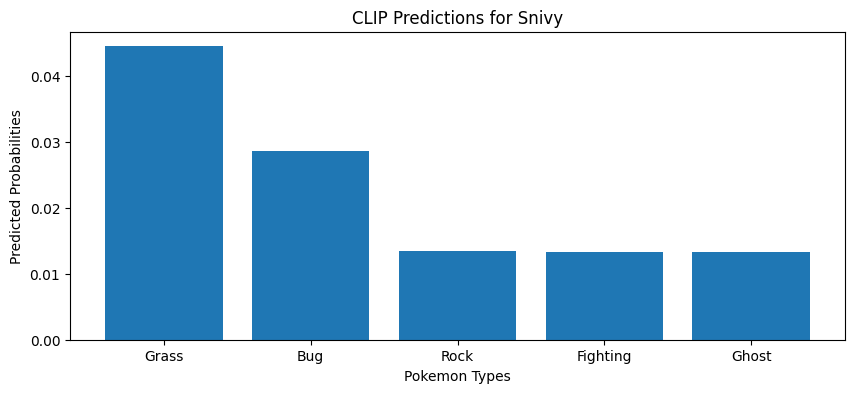



------------------Pokemon No  431  -----------------------


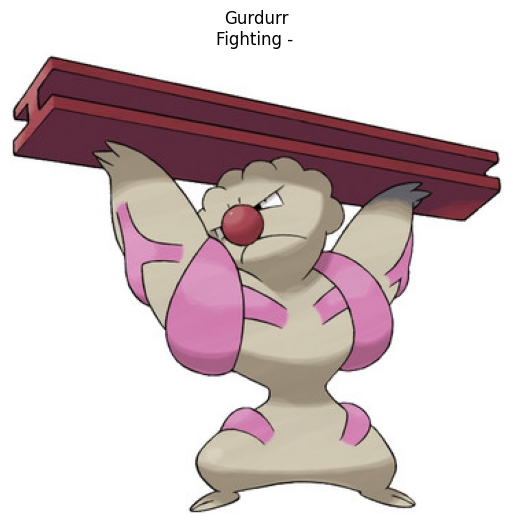

Top five types are:  ['Water', 'Fighting', 'Electric', 'Bug', 'Poison']
Top five probabilities are:  [0.01442239, 0.013468966, 0.013355791, 0.012021065, 0.011262848]


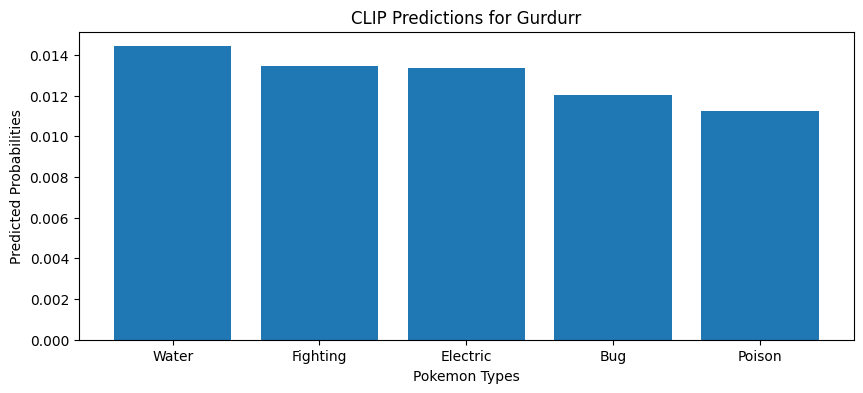



------------------Pokemon No  42  -----------------------


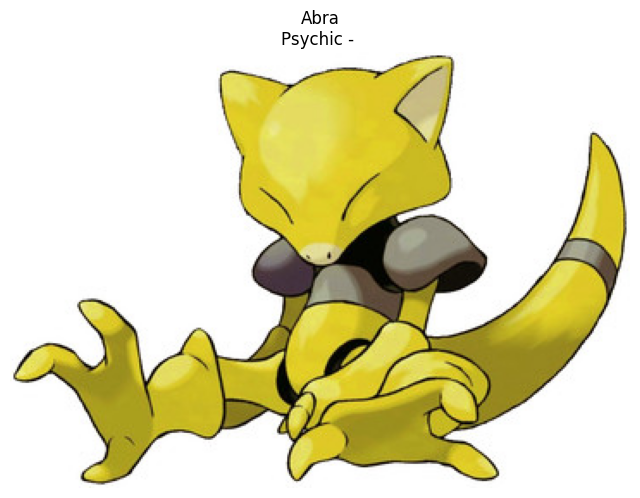

Top five types are:  ['Fairy', 'Ghost', 'Psychic', 'Normal', 'Grass']
Top five probabilities are:  [0.016664894, 0.013219326, 0.011272634, 0.009670248, 0.0085243]


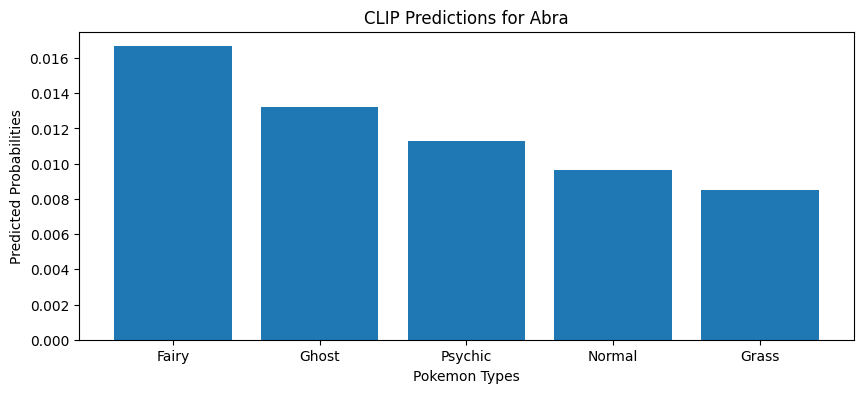



------------------Pokemon No  266  -----------------------


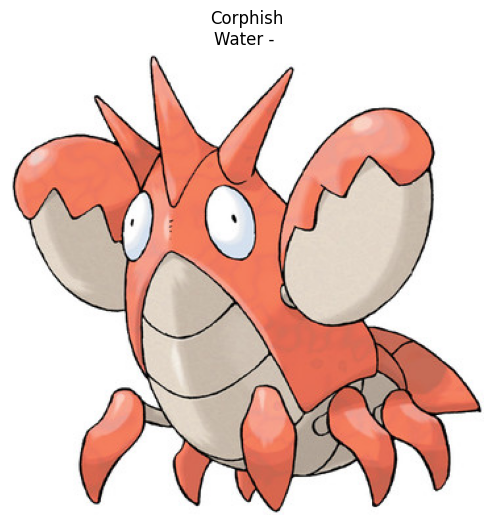

Top five types are:  ['Water', 'Fighting', 'Rock', 'Bug', 'Poison']
Top five probabilities are:  [0.047561105, 0.033682674, 0.027768934, 0.025689662, 0.0109966565]


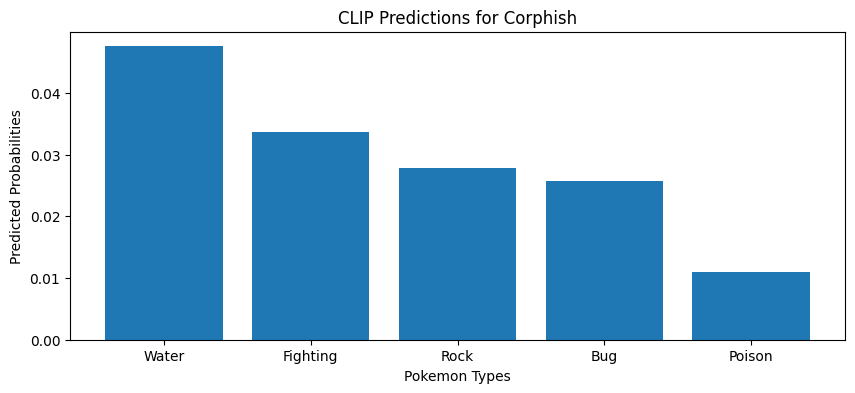



------------------Pokemon No  524  -----------------------


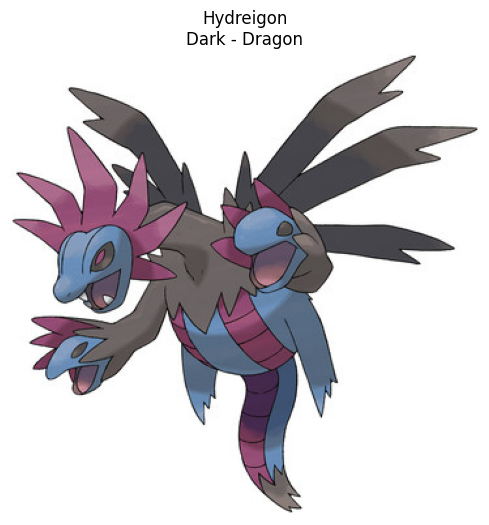

Top five types are:  ['Fighting', 'Dark', 'Ghost', 'Dragon', 'Psychic']
Top five probabilities are:  [0.045628317, 0.038835052, 0.022598857, 0.02253438, 0.021266706]


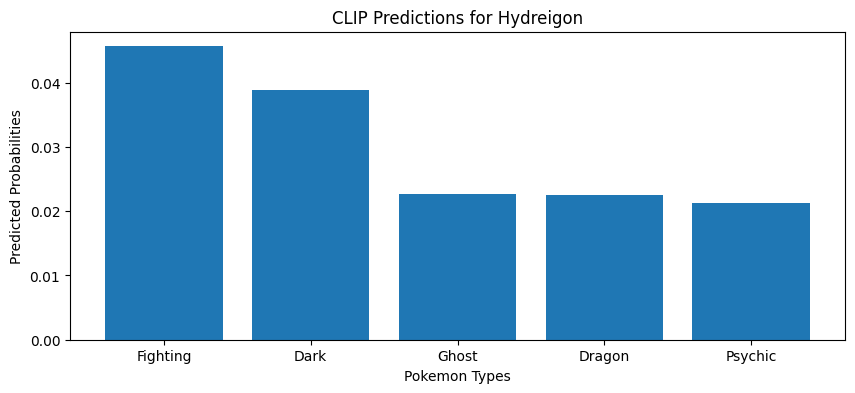



------------------Pokemon No  498  -----------------------


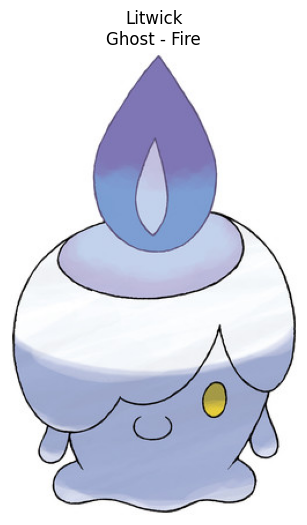

Top five types are:  ['Ghost', 'Dark', 'Fighting', 'Electric', 'Rock']
Top five probabilities are:  [0.07706201, 0.047104817, 0.040326715, 0.026028544, 0.021373445]


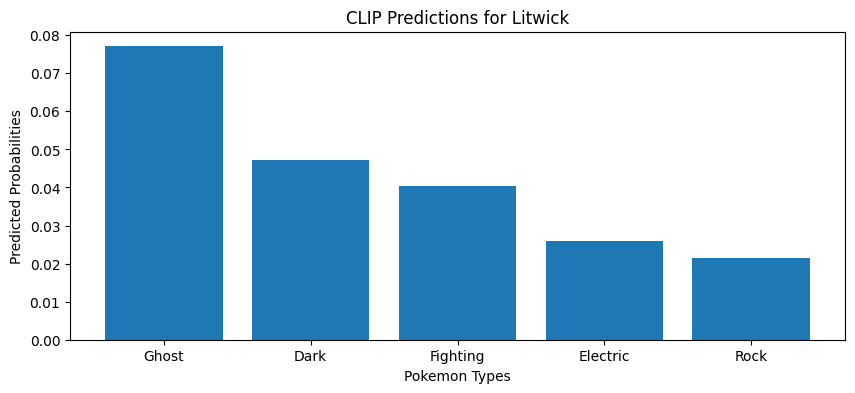



------------------Pokemon No  415  -----------------------


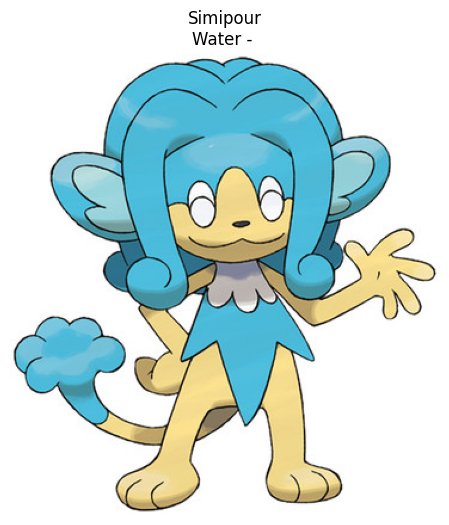

Top five types are:  ['Water', 'Fighting', 'Rock', 'Bug', 'Poison']
Top five probabilities are:  [0.047561105, 0.033682674, 0.027768934, 0.025689662, 0.0109966565]


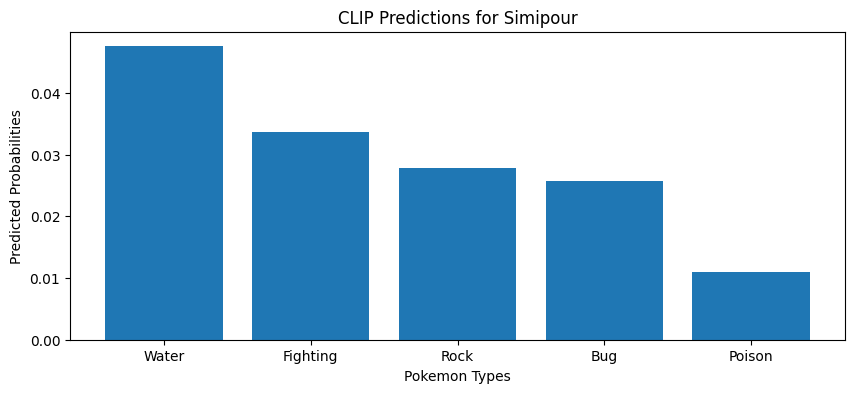



------------------Pokemon No  311  -----------------------


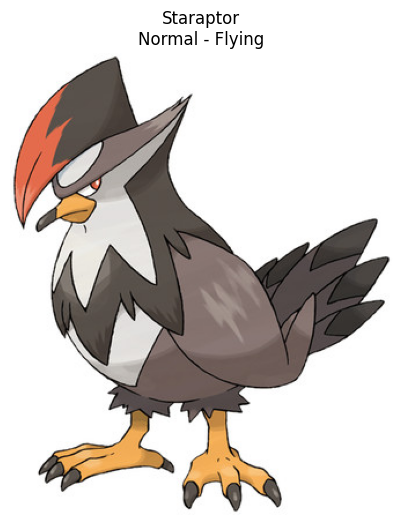

Top five types are:  ['Ground', 'Poison', 'Water', 'Dragon', 'Bug']
Top five probabilities are:  [0.011378028, 0.010374822, 0.010310394, 0.009543379, 0.008818644]


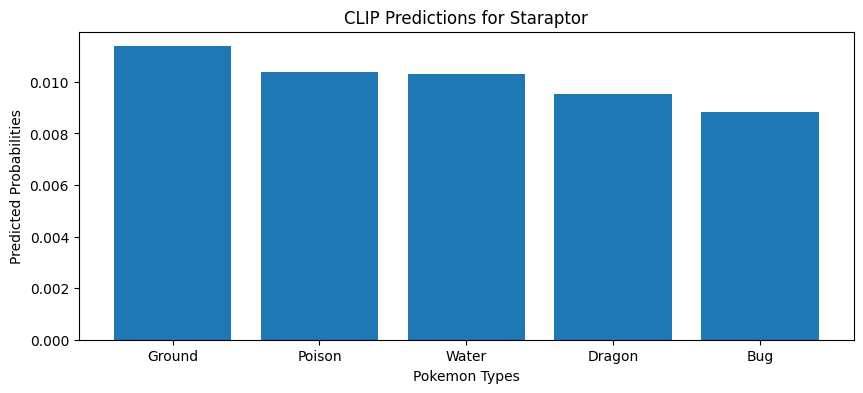



------------------Pokemon No  489  -----------------------


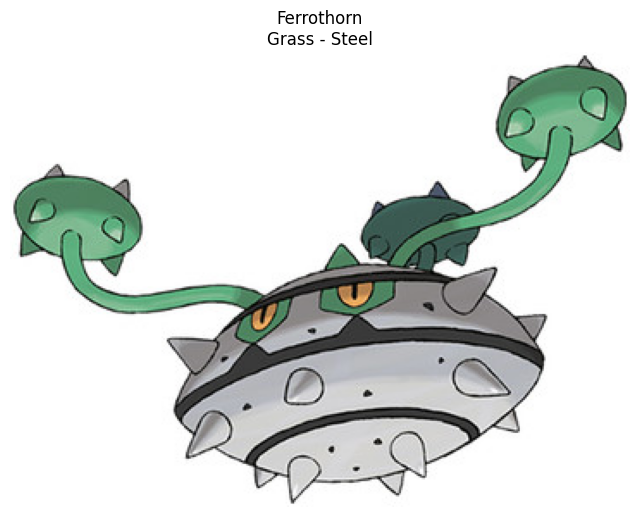

Top five types are:  ['Grass', 'Bug', 'Rock', 'Fighting', 'Ghost']
Top five probabilities are:  [0.044443645, 0.028661663, 0.01337572, 0.013232502, 0.013226294]


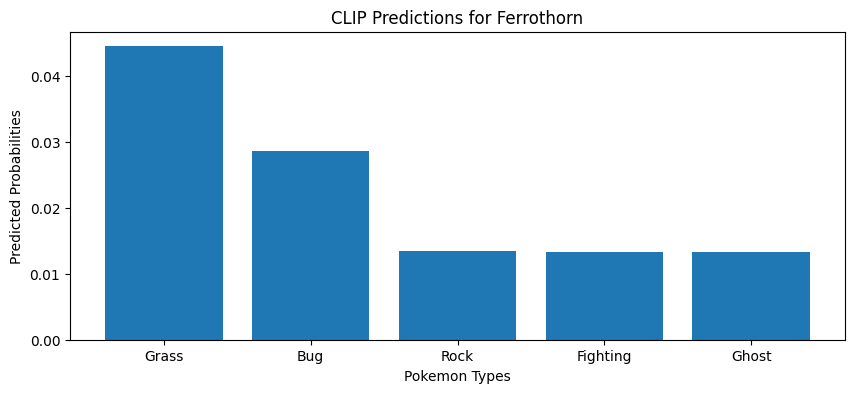



------------------Pokemon No  367  -----------------------


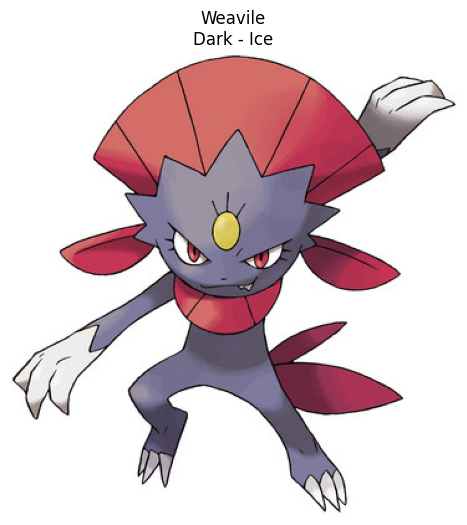

Top five types are:  ['Fighting', 'Dark', 'Ghost', 'Dragon', 'Psychic']
Top five probabilities are:  [0.045628317, 0.038835052, 0.022598857, 0.02253438, 0.021266706]


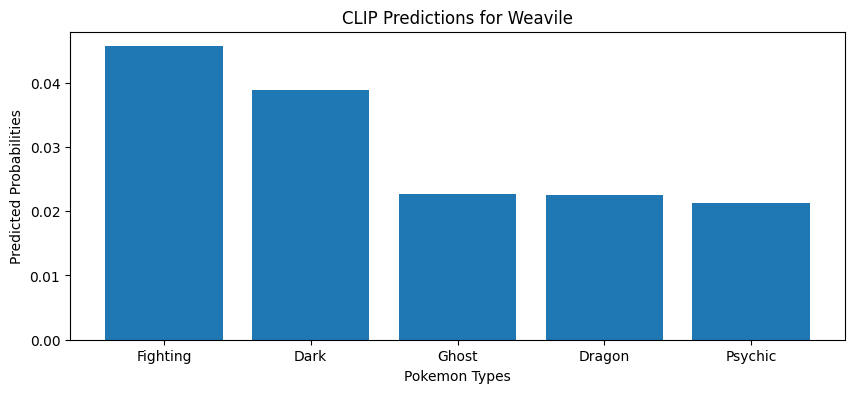

In [ ]:
# Plotting selected Pokemon and CLIP predictions only on the basis of Type 1
for index, row in selected_pokemon.iterrows():

    print("------------------Pokemon No ",index+1," -----------------------")
    # Plotting the Pokemon image
    plt.figure(figsize=(8, 6))
    img = Image.open(row['image_path'])
    plt.imshow(img)
    plt.title(f"{row['Name']}\n{row['Type1']} - {row['Type2']}")
    plt.axis('off')
    plt.show()

    # Using CLIP to find the most relevant types
    text_query = f"type: {row['Type1']}"
    text_embeddings = clip_inference_text(clip_model, clip_preprocess, [text_query], clip_device).flatten()

    # Compute similarity of text query to each image
    similarity = compute_similarity_text_to_image(np.array(pokedex['image_embeddings'].tolist()), text_embeddings)

    # Get the top five predicted types and their probabilities
    top_five_types = []
    top_five_probabilities = []
    val=1
    while(len(top_five_types)<5):
      indices = np.argsort(similarity)[::-1][val]
      pokemon_type = pokedex.loc[indices]['Type1']
      if pokemon_type not in top_five_types:
        top_five_types.append(pokemon_type)
        top_five_probabilities.append(similarity[indices])
      val+=1

    print("Top five types are: ",top_five_types)
    print("Top five probabilities are: ",top_five_probabilities)

    # Plotting the top five predicted types with probabilities
    plt.figure(figsize=(10, 4))
    plt.bar(top_five_types, top_five_probabilities)
    plt.title(f"CLIP Predictions for {row['Name']}")
    plt.xlabel("Pokemon Types")
    plt.ylabel("Predicted Probabilities")
    plt.show()

    print('\n')

------------------Pokemon No  395  -----------------------


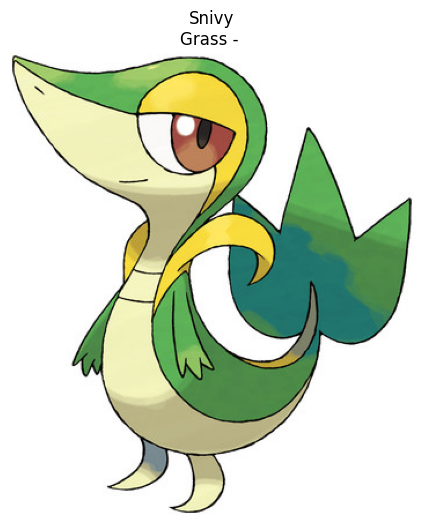

Top five types are:  ['Grass-', 'Grass-Poison', 'Ghost-Grass', 'Rock-', 'Grass-Flying']
Top five probabilities are:  [0.028647078, 0.025300492, 0.021156617, 0.01988868, 0.01602355]


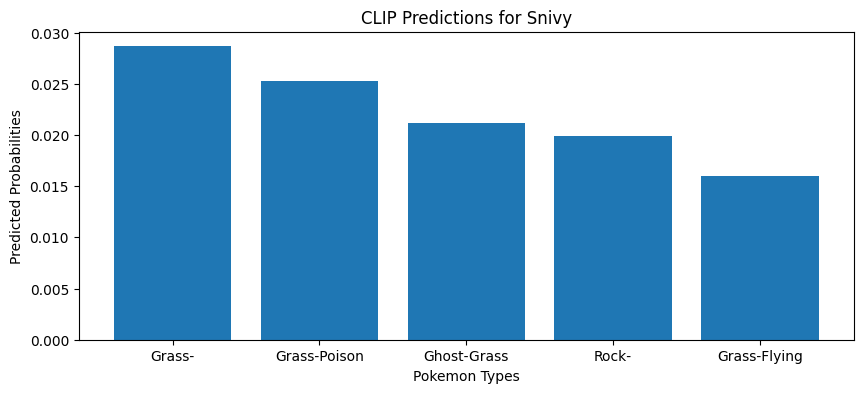



------------------Pokemon No  431  -----------------------


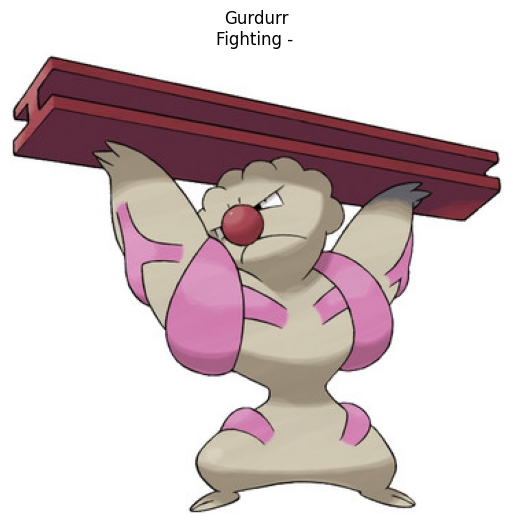

Top five types are:  ['Fighting-', 'Poison-Ground', 'Grass-Dark', 'Electric-', 'Fire-']
Top five probabilities are:  [0.021253446, 0.009355053, 0.008638209, 0.0075404607, 0.0072647696]


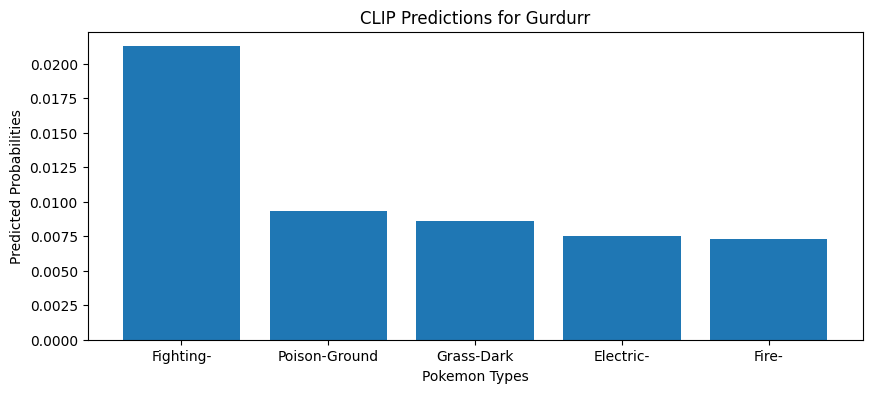



------------------Pokemon No  42  -----------------------


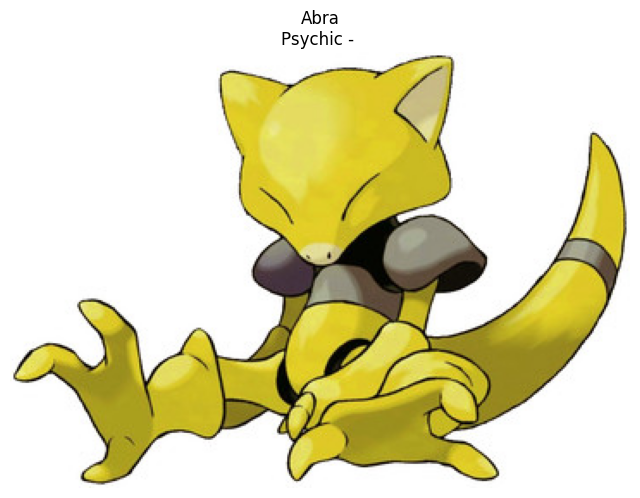

Top five types are:  ['Ghost-Dark', 'Normal-Psychic', 'Fighting-Psychic', 'Psychic-', 'Ghost-Fire']
Top five probabilities are:  [0.017863266, 0.01619507, 0.013928363, 0.010116057, 0.008807744]


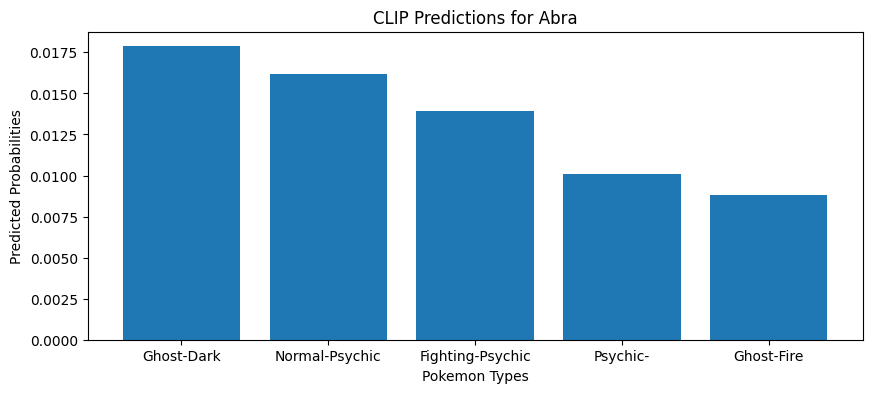



------------------Pokemon No  266  -----------------------


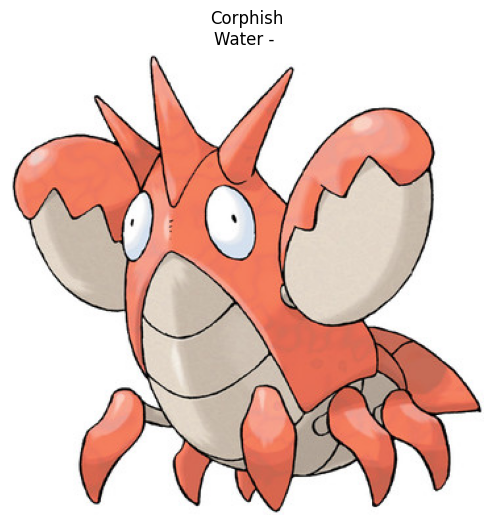

Top five types are:  ['Water-', 'Fighting-', 'Fighting-Psychic', 'Water-Ice', 'Bug-']
Top five probabilities are:  [0.039803855, 0.03081699, 0.030372743, 0.023999106, 0.0208298]


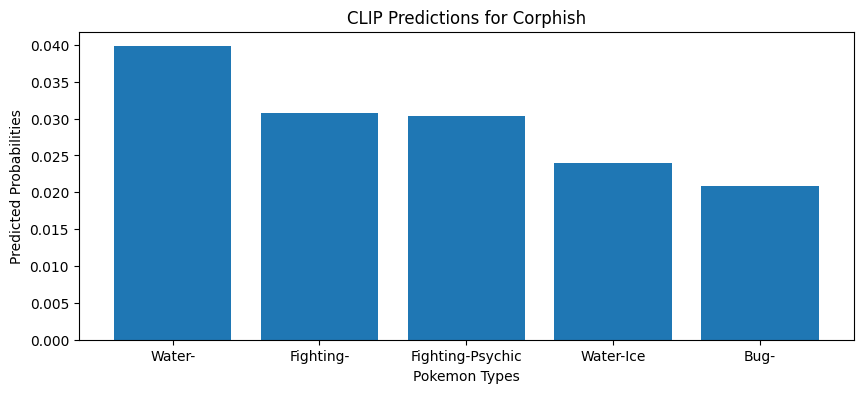



------------------Pokemon No  524  -----------------------


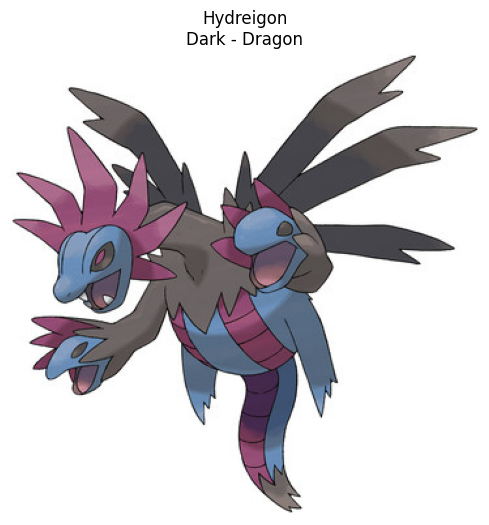

Top five types are:  ['Poison-Fire', 'Flying-Dragon', 'Dragon-Electric', 'Dragon-', 'Poison-Dragon']
Top five probabilities are:  [0.14468619, 0.07263286, 0.03359808, 0.028689658, 0.02820083]


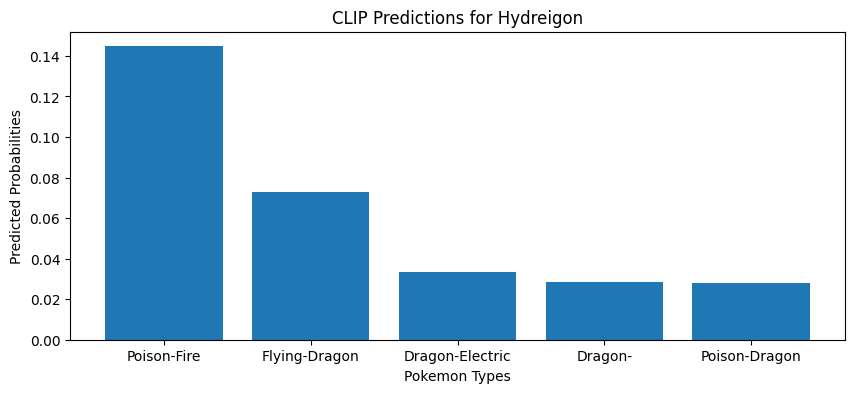



------------------Pokemon No  498  -----------------------


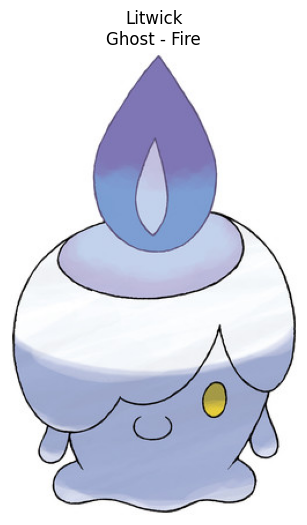

Top five types are:  ['Fighting-Ghost', 'Fire-Psychic', 'Fire-Bug', 'Ghost-Fire', 'Fire-']
Top five probabilities are:  [0.15291385, 0.051707964, 0.042517424, 0.023266807, 0.022008834]


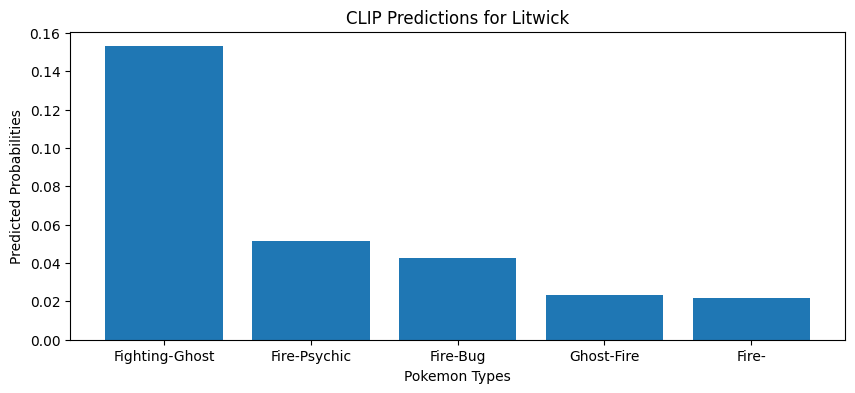



------------------Pokemon No  415  -----------------------


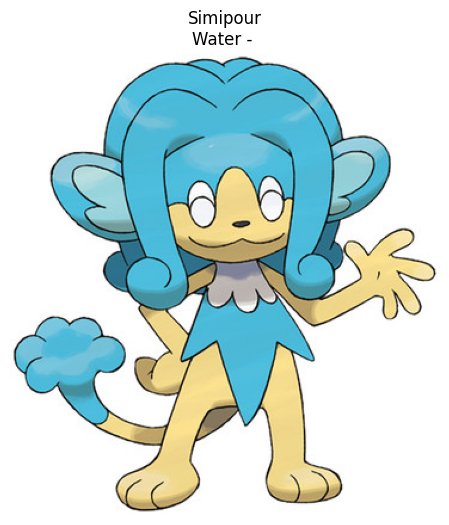

Top five types are:  ['Water-', 'Fighting-', 'Fighting-Psychic', 'Water-Ice', 'Bug-']
Top five probabilities are:  [0.039803855, 0.03081699, 0.030372743, 0.023999106, 0.0208298]


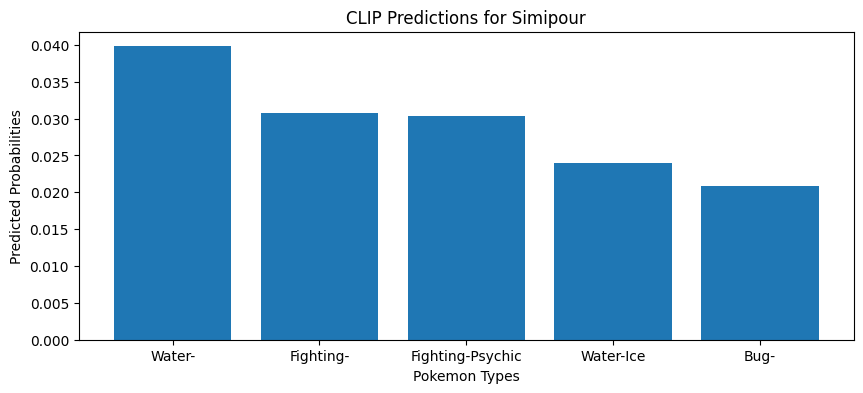



------------------Pokemon No  311  -----------------------


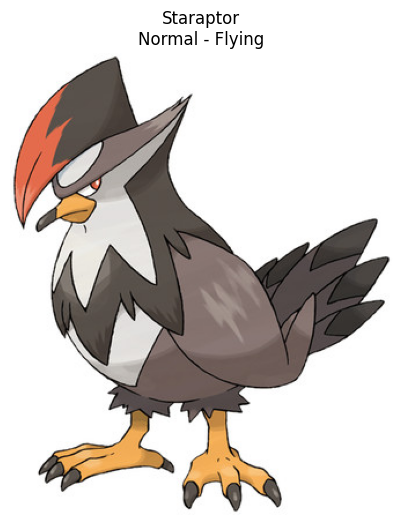

Top five types are:  ['Bug-Electric', 'Bug-Flying', 'Poison-Flying', 'Rock-Flying', 'Ground-Dragon']
Top five probabilities are:  [0.039233994, 0.038048074, 0.02962701, 0.028336532, 0.021900658]


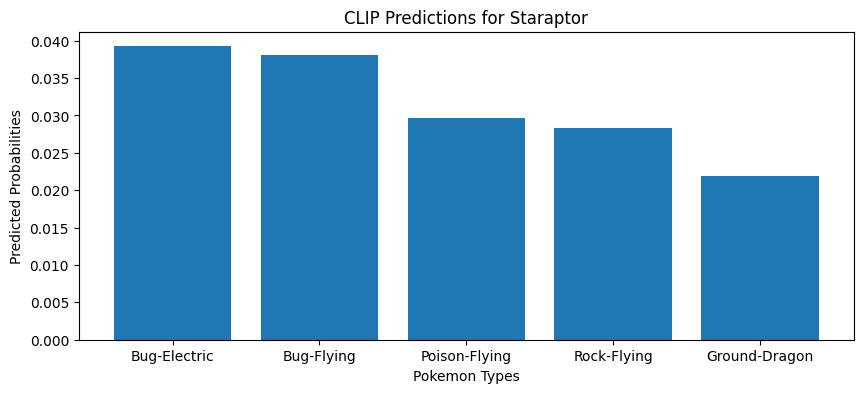



------------------Pokemon No  489  -----------------------


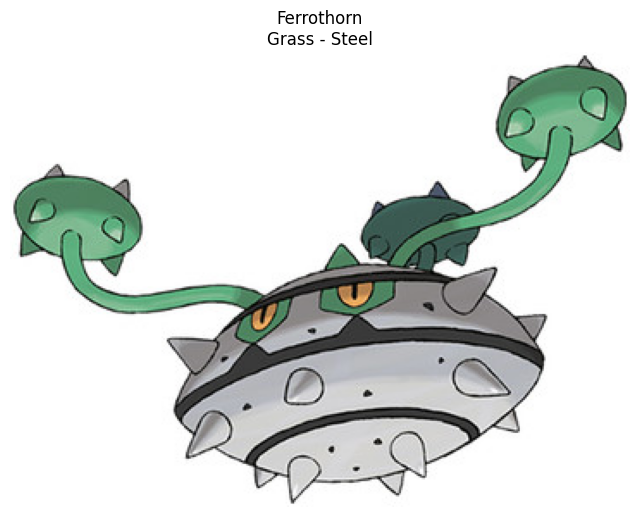

Top five types are:  ['Water-Grass', 'Normal-', 'Grass-Poison', 'Electric-', 'Grass-Dark']
Top five probabilities are:  [0.05439731, 0.038959887, 0.031267196, 0.030867457, 0.027516888]


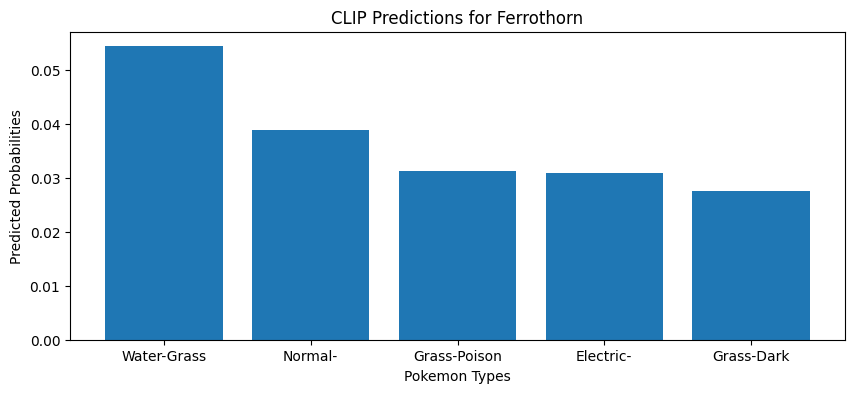



------------------Pokemon No  367  -----------------------


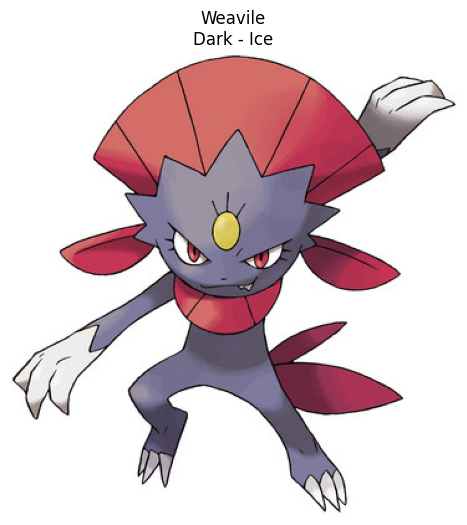

Top five types are:  ['Ice-', 'Rock-Fairy', 'Dark-', 'Electric-', 'Dark-Dragon']
Top five probabilities are:  [0.15948467, 0.070260204, 0.028377406, 0.02343031, 0.018104127]


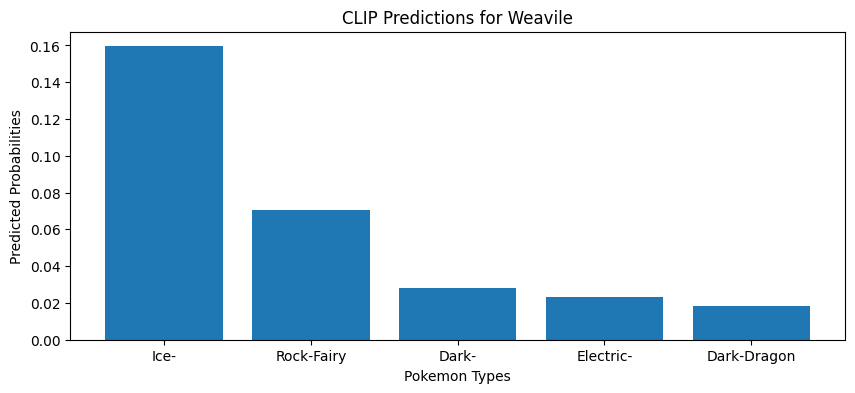

In [ ]:
# Plotting selected Pokemon and CLIP predictions on the basis of Type 1 - Type 2
for index, row in selected_pokemon.iterrows():

    print("------------------Pokemon No ",index+1," -----------------------")
    # Plotting the Pokemon image
    plt.figure(figsize=(8, 6))
    img = Image.open(row['image_path'])
    plt.imshow(img)
    plt.title(f"{row['Name']}\n{row['Type1']} - {row['Type2']}")
    plt.axis('off')
    plt.show()

    # Using CLIP to find the most relevant types
    text_query = f"type: {row['Type1']}, {row['Type2']}"
    text_embeddings = clip_inference_text(clip_model, clip_preprocess, [text_query], clip_device).flatten()

    # Compute similarity of text query to each image
    similarity = compute_similarity_text_to_image(np.array(pokedex['image_embeddings'].tolist()), text_embeddings)

    # Get the top five predicted types and their probabilities
    top_five_types = []
    top_five_probabilities = []
    val=1
    while(len(top_five_types)<5):
      indices = np.argsort(similarity)[::-1][val]
      pokemon_type_1 = pokedex.loc[indices]['Type1']
      pokemon_type_2 = pokedex.loc[indices]['Type2']
      if ''.join([pokemon_type_1,"-",pokemon_type_2]) not in top_five_types:
        top_five_types.append(''.join([pokemon_type_1,"-",pokemon_type_2]))
        top_five_probabilities.append(similarity[indices])
      val+=1

    print("Top five types are: ",top_five_types)
    print("Top five probabilities are: ",top_five_probabilities)

    # Plotting the top five predicted types with probabilities
    plt.figure(figsize=(10, 4))
    plt.bar(top_five_types, top_five_probabilities)
    plt.title(f"CLIP Predictions for {row['Name']}")
    plt.xlabel("Pokemon Types")
    plt.ylabel("Predicted Probabilities")
    plt.show()

    print('\n')

QUESTION 27: Randomly select 10 Pokemon images from the dataset and use CLIP to find the most relevant types (use your preferred template, e.g ”type: Bug”). For each selected Pokemon, please plot it and indicate:
* its name and first and second type;
* the five most relevant types predicted by CLIP and their predicted probabilities.

> We can see the pokemons and the corresponding relevant types above.

# **Question 28**

In [ ]:
# Selecting Pokemon types Bug, Fire, and Grass
selected_types = ['Bug', 'Fire', 'Grass']
selected_pokemon = pokedex[pokedex['Type1'].isin(selected_types)].reset_index(drop=True)

# Getting image embeddings for selected Pokemon
selected_image_paths = selected_pokemon['image_path'].tolist()
selected_image_embeddings = clip_inference_image(clip_model, clip_preprocess, selected_image_paths, clip_device)

# Use t-SNE to project CLIP embeddings to 2D space
tsne_data = umap_projection(selected_image_embeddings)

# Create scatter plot with Plotly
fig = px.scatter(selected_pokemon, x=tsne_data[:, 0], y=tsne_data[:, 1], color='Type1',
                 hover_name='Name', title='t-SNE Visualization of Pokemon Clusters',
                 labels={'tsne_x': 't-SNE Dimension 1', 'tsne_y': 't-SNE Dimension 2'})

# Show the plot
fig.show()


100%|██████████| 192/192 [10:14<00:00,  3.20s/it]


QUESTION 28: In the first and second question, we investigated how CLIP creates ’clusters’ by mapping images and texts of various Pokemon into a high-dimensional space and explored neighbor- hood of these items in this space. For this question, please use t-SNE to visualize image clusters, specifically for Pokemon types Bug, Fire, and Grass. You can use scatter plot from python package plotly. For the visualization, color-code each point based on its first type type 1 using the ’color’ argument, and label each point with the Pokemon’s name and types using ’hover name’. This will enable you to identify each Pokemon represented in your visualization. After completing the visualization, analyze it and discuss whether the clustering of Pokemon types make sense to you.

> The graph above shows the plot for the Pokemon types Bug, Fire and Grass. We can see that three clusters are formed. They are not very distinct. The bottom left corner depicts a cluster of Bug Pokemon. The top tight blue cluster represents Grass. The spread out red cluster is Fire. We notice that we do not have well defined clusters because there are certain characteristics that are overlapping and hence we can see the overlapping of two clusters and some point being plotted in between. We can see that fire has the most spread out cluster as compared to the other two pokemon types.